In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/disk")

Mounted at /content/disk


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat[0].argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [ ]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:05<00:00, 108089729.99it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
train_dataset.targets.shape

torch.Size([60000])

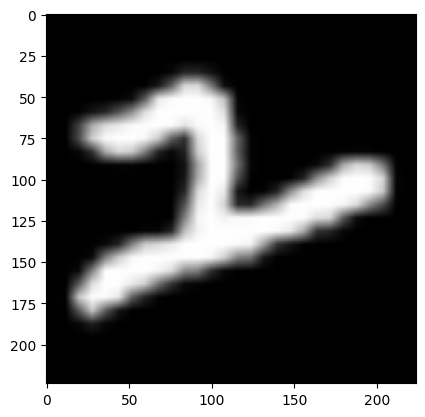

In [ ]:
plt.imshow(train_dataset[0][1].numpy().reshape(224,224), cmap='gray');

In [ ]:
model = tv.models.resnet18(pretrained=True)
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=10)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train_loss_resnet18=train(model, train_iter, test_iter, trainer, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0. time since epoch: 7.588. Train acc: 0.105. Train Loss: 2.394
Step 100. time since epoch: 68.634. Train acc: 0.795. Train Loss: 0.944
Step 200. time since epoch: 130.595. Train acc: 0.862. Train Loss: 0.651
--------------------
epoch 1, loss 0.5986, train acc 0.873, test acc 0.945, time 167.3 sec
Step 0. time since epoch: 0.569. Train acc: 0.910. Train Loss: 0.302
Step 100. time since epoch: 60.885. Train acc: 0.948. Train Loss: 0.236
Step 200. time since epoch: 121.395. Train acc: 0.951. Train Loss: 0.218
--------------------
epoch 2, loss 0.2138, train acc 0.952, test acc 0.958, time 157.6 sec
Step 0. time since epoch: 0.568. Train acc: 0.930. Train Loss: 0.223
Step 100. time since epoch: 60.652. Train acc: 0.959. Train Loss: 0.170
Step 200. time since epoch: 120.646. Train acc: 0.960. Train Loss: 0.164
--------------------
epoch 3, loss 0.1618, train acc 0.960, test acc 0.964, time 156.7 sec
Step 0. time since epoch: 0.570. Train acc: 0.941. Train Loss: 0.190
Step 100. time s

In [ ]:
model = tv.models.densenet161(pretrained=True)
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(in_features=2208, out_features=10)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train_loss_densenet161=train(model, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 2.429. Train acc: 0.078. Train Loss: 2.337
Step 100. time since epoch: 245.578. Train acc: 0.805. Train Loss: 0.863
Step 200. time since epoch: 488.425. Train acc: 0.866. Train Loss: 0.604
--------------------
epoch 1, loss 0.5579, train acc 0.876, test acc 0.942, time 642.2 sec
Step 0. time since epoch: 2.346. Train acc: 0.941. Train Loss: 0.290
Step 100. time since epoch: 225.407. Train acc: 0.947. Train Loss: 0.230
Step 200. time since epoch: 448.844. Train acc: 0.950. Train Loss: 0.212
--------------------
epoch 2, loss 0.2083, train acc 0.951, test acc 0.956, time 595.7 sec
Step 0. time since epoch: 2.186. Train acc: 0.945. Train Loss: 0.209
Step 100. time since epoch: 225.549. Train acc: 0.960. Train Loss: 0.163
Step 200. time since epoch: 448.624. Train acc: 0.961. Train Loss: 0.157
--------------------
epoch 3, loss 0.1562, train acc 0.961, test acc 0.961, time 595.7 sec
Step 0. time since epoch: 2.343. Train acc: 0.953. Train Loss: 0.171
Step 100. tim

In [ ]:
model = tv.models.vgg16(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = tv.models.vgg16(pretrained=True)
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train_loss_vgg16=train(model, train_iter, test_iter, trainer, 10)

	 classifier.6.weight
	 classifier.6.bias
Step 0. time since epoch: 2.056. Train acc: 0.105. Train Loss: 2.321
Step 100. time since epoch: 170.374. Train acc: 0.770. Train Loss: 0.827
Step 200. time since epoch: 338.075. Train acc: 0.819. Train Loss: 0.638
--------------------
epoch 1, loss 0.6050, train acc 0.827, test acc 0.930, time 445.4 sec
Step 0. time since epoch: 1.629. Train acc: 0.957. Train Loss: 0.273
Step 100. time since epoch: 169.098. Train acc: 0.942. Train Loss: 0.254
Step 200. time since epoch: 337.170. Train acc: 0.945. Train Loss: 0.232
--------------------
epoch 2, loss 0.2267, train acc 0.946, test acc 0.953, time 444.6 sec
Step 0. time since epoch: 1.638. Train acc: 0.961. Train Loss: 0.164
Step 100. time since epoch: 169.090. Train acc: 0.959. Train Loss: 0.171
Step 200. time since epoch: 336.552. Train acc: 0.959. Train Loss: 0.164
--------------------
epoch 3, loss 0.1619, train acc 0.960, test acc 0.963, time 443.7 sec
Step 0. time since epoch: 1.669. Train a

In [ ]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model = tv.models.inception_v3(pretrained=True)
model = model.to(device)

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat.argmax(axis=1) == y).sum()
        n += y.shape[0]
        return 0
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=2048, out_features=10)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
trainer = torch.optim.Adam(params_to_update, lr=0.001)
train_loss_inception_v3=train(model, train_iter, test_iter, trainer, 10)

	 fc.weight
	 fc.bias
Step 0. time since epoch: 1.729. Train acc: 0.105. Train Loss: 2.332
Step 100. time since epoch: 177.252. Train acc: 0.683. Train Loss: 1.202
Step 200. time since epoch: 357.646. Train acc: 0.750. Train Loss: 0.935
--------------------
epoch 1, loss 0.8862, train acc 0.761, test acc 0.000, time 418.5 sec
Step 0. time since epoch: 2.117. Train acc: 0.848. Train Loss: 0.577
Step 100. time since epoch: 182.816. Train acc: 0.844. Train Loss: 0.530
Step 200. time since epoch: 362.317. Train acc: 0.848. Train Loss: 0.510
--------------------
epoch 2, loss 0.5058, train acc 0.849, test acc 0.000, time 422.7 sec
Step 0. time since epoch: 2.161. Train acc: 0.855. Train Loss: 0.500
Step 100. time since epoch: 182.998. Train acc: 0.856. Train Loss: 0.457
Step 200. time since epoch: 363.527. Train acc: 0.859. Train Loss: 0.449
--------------------
epoch 3, loss 0.4475, train acc 0.859, test acc 0.000, time 424.1 sec
Step 0. time since epoch: 2.130. Train acc: 0.855. Train Los

In [ ]:
with open('train_loss_resnet18.txt', 'w') as filehandle:
  for listitem in train_loss_resnet18: filehandle.write('%s\n' % listitem)
with open('train_loss_densenet161.txt', 'w') as filehandle:
  for listitem in train_loss_densenet161: filehandle.write('%s\n' % listitem)
with open('train_loss_vgg16.txt', 'w') as filehandle:
  for listitem in train_loss_vgg16: filehandle.write('%s\n' % listitem)
with open('train_loss_inception_v3.txt', 'w') as filehandle:
  for listitem in train_loss_inception_v3: filehandle.write('%s\n' % listitem)

In [ ]:
def get_list(name):
  list = [] # open file and read the content in a list
  nameFile='disk/MyDrive/Colab Notebooks/train_loss_'+name+'.txt'
  with open(nameFile, 'r') as filehandle:
    for line in filehandle:
      currentPlace = line[:-1]
      list.append(currentPlace)
  return list

In [ ]:
import pandas as pd
df=pd.DataFrame()
for file in ['densenet161','resnet18','vgg16','inception_v3']:
  df[file]=get_list(file)
df

,densenet161,resnet18,vgg16,inception_v3
0,0.5579128850301107,0.5985623298009237,0.6050189657211303,0.8861503180185953
1,0.20829454860687255,0.21375242579778037,0.22673670482635497,0.5057969849904378
2,0.15616221227645874,0.1618321361541748,0.16189049263000488,0.4475391455332438
3,0.1306688444137573,0.13708691178957622,0.13114030125935872,0.420348814646403
4,0.11479521843592326,0.12194435890515645,0.11191433273951212,0.4010060544331869
5,0.10364506781895956,0.1114611257870992,0.09838330376942953,0.3948290496190389
6,0.09522140868504843,0.10364415211677551,0.08815297667980194,0.39030328381856283
7,0.0885407996336619,0.09751512198448181,0.08002933260599772,0.3809208676020304
8,0.08305559536616007,0.0925324975013733,0.07334711170991262,0.3773638962427775
9,0.07843327859242757,0.08837054767608643,0.06770118295351664,0.3737822489420573


<ipython-input-80-af4d14061e8f>:1: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( df['densenet161'], 'o-r', label='densenet161', linestyle='--')
<ipython-input-80-af4d14061e8f>:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df['resnet18'], 'o-r', label='resnet18', linestyle='--')
<ipython-input-80-af4d14061e8f>:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-.g" (-> linestyle='-.'). The keyword argument will take precedence.
  plt.plot(df['vgg16'],'o-.g', label='vgg16', linestyle='--')
<ipython-input-80-af4d14061e8f>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-.y" (-> linestyle='-.'). The keyword ar

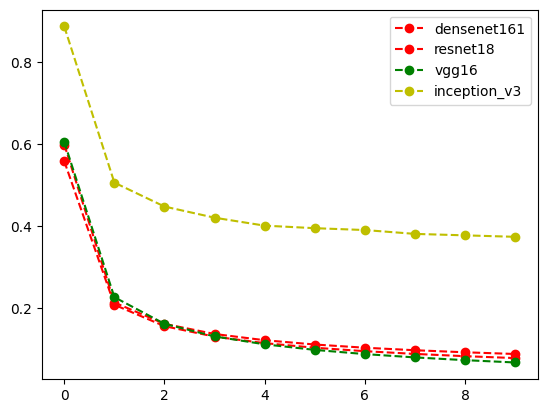

In [ ]:
df=df.astype(float)
plt.plot( df['densenet161'], 'o-r', label='densenet161', linestyle='--')
plt.plot(df['resnet18'], 'o-r', label='resnet18', linestyle='--')
plt.plot(df['vgg16'],'o-.g', label='vgg16', linestyle='--')
plt.plot(df['inception_v3'],'o-.y', label='inception_v3', linestyle='--')
plt.legend()